In [2]:
#!pip install --upgrade scikit-learn imbalanced-learn
#############
### In this Approach we have model for each class and predict ShipMode Base On proba ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix
from sklearn.preprocessing import RobustScaler , StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
warnings.filterwarnings('ignore')

In [2]:
######################## Dataset ###########################

In [3]:
data_all = pd.read_excel("data.xlsx",sheet_name = None)

In [4]:
order_sheet = data_all["order"]

In [5]:
product_sheet = data_all["product"]
returned_sheet = data_all["returned"]
shipping_sheet = data_all["shipping"]
order_detail_sheet = data_all["order_detail"]
customer_sheet = data_all["customer"]

In [6]:
shipping_details_join = pd.merge(shipping_sheet,order_detail_sheet, how="inner", on="Order ID")
shipping_details_order_join = pd.merge(shipping_details_join,order_sheet,how = "inner", on = "Order ID")
shipping_details_order_customer = pd.merge(shipping_details_order_join,customer_sheet,how = "inner", on = "Customer ID")
shipping_details_order_customer_product = pd.merge(shipping_details_order_customer,product_sheet,how = "inner", on = "Product ID")

In [7]:
shipping_details_order_customer_product['Order Day Number'] = shipping_details_order_customer_product['Order Date'].dt.dayofweek

In [8]:
shipping_details_order_customer_product

,Shipping ID,Order ID,Ship Date,Ship Mode,City,State,Country,Region,Index,Product ID,...,Market,Customer Name,Segment,Product Name,Brand,Type,Description,Category,Sub-Category,Order Day Number
0,35085,CA-2012-115945,2012-07-01,Standard Class,Los Angeles,California,United States,West,34361,OFF-AR-10004062,...,Us,Alan Barnes,Consumer,Staples,Staples,NaN,NaN,Office Supplies,Art,0
1,35085,CA-2012-115945,2012-07-01,Standard Class,Los Angeles,California,United States,West,34363,OFF-ST-10001963,...,Us,Alan Barnes,Consumer,Tennsco Regal Shelving Units,Tennsco,Regal Shelving Units,NaN,Office Supplies,Storage,0
2,35085,CA-2012-115945,2012-07-01,Standard Class,Los Angeles,California,United States,West,34362,OFF-BI-10004330,...,Us,Alan Barnes,Consumer,"Gbc Velobind Prepunched Cover Sets, Regency Se...",Gbc,Velobind Prepunched Cover Sets,Regency Series,Office Supplies,Binders,0
3,40644,CA-2011-101462,2011-04-25,Standard Class,Los Angeles,California,United States,West,36882,FUR-FU-10000409,...,Us,Benjamin Patterson,Consumer,"Ge 4 Foot Flourescent Tube, 40 Watt",Ge,4 Foot Flourescent Tube,40 Watt,Furniture,Furnishings,2
4,35333,CA-2011-107139,2011-07-11,Standard Class,Los Angeles,California,United States,West,33837,OFF-BI-10001670,...,Us,Dennis Pardue,Home Office,Vinyl Sectional Post Binders,Vinyl,Sectional Post Binders,NaN,Office Supplies,Binders,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49630,25660,MX-2012-125262,2012-09-17,Standard Class,San Salvador,San Salvador,El Salvador,Central,8536,TEC-AC-10003955,...,Latam,Jas O'Carroll,Consumer,"Memorex Router, Erganomic",Memorex,Router,Erganomic,Technology,Accessories,3
49631,30536,MX-2013-160248,2013-06-30,Standard Class,San Salvador,San Salvador,El Salvador,Central,308,FUR-BO-10002782,...,Latam,Jason Gross,Corporate,"Safco Corner Shelving, Traditional",Safco,Corner Shelving,Traditional,Furniture,Bookcases,2
49632,30536,MX-2013-160248,2013-06-30,Standard Class,San Salvador,San Salvador,El Salvador,Central,307,FUR-CH-10004338,...,Latam,Jason Gross,Corporate,"Hon Bag Chairs, Red",Hon,Bag Chairs,Red,Furniture,Chairs,2
49633,27783,MX-2014-121993,2014-06-15,Standard Class,San Salvador,San Salvador,El Salvador,Central,5975,TEC-PH-10002332,...,Latam,Julia Dunbar,Consumer,"Motorola Audio Dock, Voip",Motorola,Audio Dock,Voip,Technology,Phones,2


In [9]:
############ Select Features ##########

In [10]:
dataframe = shipping_details_order_customer_product.copy()

In [11]:
selected_dataframe = dataframe[["Order ID","Order Day Number","Market","Category","Sub-Category","Order Priority","Region","Sales","Discount","Profit","Quantity","Segment","Ship Mode"]]

In [12]:
selected_dataframe

,Order ID,Order Day Number,Market,Category,Sub-Category,Order Priority,Region,Sales,Discount,Profit,Quantity,Segment,Ship Mode
0,CA-2012-115945,0,Us,Office Supplies,Art,Medium,West,20.960,0.0,5.2400,2,Consumer,Standard Class
1,CA-2012-115945,0,Us,Office Supplies,Storage,Medium,West,304.230,0.0,9.1269,3,Consumer,Standard Class
2,CA-2012-115945,0,Us,Office Supplies,Binders,Medium,West,88.752,0.2,27.7350,3,Consumer,Standard Class
3,CA-2011-101462,2,Us,Furniture,Furnishings,Medium,West,59.920,0.0,27.5632,4,Consumer,Standard Class
4,CA-2011-107139,1,Us,Office Supplies,Binders,Medium,West,180.960,0.2,67.8600,6,Home Office,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49630,MX-2012-125262,3,Latam,Technology,Accessories,High,Central,650.720,0.0,299.2800,4,Consumer,Standard Class
49631,MX-2013-160248,2,Latam,Furniture,Bookcases,Medium,Central,199.280,0.0,89.6400,2,Corporate,Standard Class
49632,MX-2013-160248,2,Latam,Furniture,Chairs,Medium,Central,180.600,0.0,7.2000,6,Corporate,Standard Class
49633,MX-2014-121993,2,Latam,Technology,Phones,High,Central,346.920,0.0,0.0000,3,Consumer,Standard Class


In [13]:
selected_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49635 entries, 0 to 49634
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order ID          49635 non-null  object 
 1   Order Day Number  49635 non-null  int32  
 2   Market            49635 non-null  object 
 3   Category          49635 non-null  object 
 4   Sub-Category      49635 non-null  object 
 5   Order Priority    49635 non-null  object 
 6   Region            49635 non-null  object 
 7   Sales             49635 non-null  float64
 8   Discount          49635 non-null  float64
 9   Profit            49635 non-null  float64
 10  Quantity          49635 non-null  int64  
 11  Segment           49635 non-null  object 
 12  Ship Mode         49635 non-null  object 
dtypes: float64(3), int32(1), int64(1), object(8)
memory usage: 4.7+ MB


In [14]:
selected_dataframe["Ship Mode"].unique()

array(['Standard Class', 'Second Class', 'First Class', 'Same Day'],
      dtype=object)

In [15]:
############### Encode features ##################

In [16]:
def Encode_order_priority(order):
    if order == "Low":
        return 1
    elif order == "Medium":
        return 2
    elif order == "High":
        return 3
    elif order == "Critical":
        return 4

In [17]:
def Encode_order_shipmode(order):
    if order == "Standard Class":
        return 1
    elif order == "Second Class":
        return 2
    elif order == "First Class":
        return 3
    elif order == "Same Day":
        return 4

In [18]:
selected_dataframe["Order Priority"] = selected_dataframe["Order Priority"].apply(lambda x:Encode_order_priority(x))

In [19]:
selected_dataframe["Ship Mode"] = selected_dataframe["Ship Mode"].apply(lambda x:Encode_order_shipmode(x))

In [20]:
selected_dataframe

,Order ID,Order Day Number,Market,Category,Sub-Category,Order Priority,Region,Sales,Discount,Profit,Quantity,Segment,Ship Mode
0,CA-2012-115945,0,Us,Office Supplies,Art,2,West,20.960,0.0,5.2400,2,Consumer,1
1,CA-2012-115945,0,Us,Office Supplies,Storage,2,West,304.230,0.0,9.1269,3,Consumer,1
2,CA-2012-115945,0,Us,Office Supplies,Binders,2,West,88.752,0.2,27.7350,3,Consumer,1
3,CA-2011-101462,2,Us,Furniture,Furnishings,2,West,59.920,0.0,27.5632,4,Consumer,1
4,CA-2011-107139,1,Us,Office Supplies,Binders,2,West,180.960,0.2,67.8600,6,Home Office,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49630,MX-2012-125262,3,Latam,Technology,Accessories,3,Central,650.720,0.0,299.2800,4,Consumer,1
49631,MX-2013-160248,2,Latam,Furniture,Bookcases,2,Central,199.280,0.0,89.6400,2,Corporate,1
49632,MX-2013-160248,2,Latam,Furniture,Chairs,2,Central,180.600,0.0,7.2000,6,Corporate,1
49633,MX-2014-121993,2,Latam,Technology,Phones,3,Central,346.920,0.0,0.0000,3,Consumer,1


In [21]:
selected_dataframe_with_encoding = pd.get_dummies(selected_dataframe,columns=['Market','Category','Sub-Category','Region','Segment'], prefix=['Market','Category','Sub-Cat','Region','Segment'],dtype=int)

In [22]:
selected_dataframe_with_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49635 entries, 0 to 49634
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order ID                  49635 non-null  object 
 1   Order Day Number          49635 non-null  int32  
 2   Order Priority            49635 non-null  int64  
 3   Sales                     49635 non-null  float64
 4   Discount                  49635 non-null  float64
 5   Profit                    49635 non-null  float64
 6   Quantity                  49635 non-null  int64  
 7   Ship Mode                 49635 non-null  int64  
 8   Market_Africa             49635 non-null  int64  
 9   Market_Apac               49635 non-null  int64  
 10  Market_Canada             49635 non-null  int64  
 11  Market_Emea               49635 non-null  int64  
 12  Market_Eu                 49635 non-null  int64  
 13  Market_Latam              49635 non-null  int64  
 14  Market

In [23]:
####### Resample and RobustScaler #######

In [24]:
unique_ids = selected_dataframe_with_encoding["Order ID"].unique()

In [25]:
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

In [26]:
train_data = selected_dataframe_with_encoding[selected_dataframe_with_encoding["Order ID"].isin(train_ids)]
test_data = selected_dataframe_with_encoding[selected_dataframe_with_encoding["Order ID"].isin(test_ids)]

In [27]:
X_train = train_data.drop(columns=['Ship Mode', 'Order ID'])
y_train = train_data[['Ship Mode']]
X_test = test_data.drop(columns=['Ship Mode', 'Order ID'])
y_test = test_data[['Ship Mode']]

In [28]:
X_train

,Order Day Number,Order Priority,Sales,Discount,Profit,Quantity,Market_Africa,Market_Apac,Market_Canada,Market_Emea,...,Region_Emea,Region_North,Region_North Asia,Region_Oceania,Region_South,Region_Southeast Asia,Region_West,Segment_Consumer,Segment_Corporate,Segment_Home Office
0,0,2,20.960,0.0,5.2400,2,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,2,304.230,0.0,9.1269,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,2,88.752,0.2,27.7350,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,2,2,59.920,0.0,27.5632,4,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,1,2,180.960,0.2,67.8600,6,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49628,2,2,67.340,0.0,18.0600,7,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
49629,2,2,169.760,0.0,74.5600,8,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
49630,3,3,650.720,0.0,299.2800,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
49633,2,3,346.920,0.0,0.0000,3,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
y_train[y_train['Ship Mode'] == 3]

,Ship Mode
604,3
609,3
613,3
614,3
615,3
...,...
17709,3
17710,3
17711,3
17712,3


In [30]:
smote = SMOTE(sampling_strategy={2:12000 , 3:12000 , 4:12000}, k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(sampling_strategy='majority', replacement=False, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_smote, y_train_smote)


In [31]:
X_train_resampled

,Order Day Number,Order Priority,Sales,Discount,Profit,Quantity,Market_Africa,Market_Apac,Market_Canada,Market_Emea,...,Region_Emea,Region_North,Region_North Asia,Region_Oceania,Region_South,Region_Southeast Asia,Region_West,Segment_Consumer,Segment_Corporate,Segment_Home Office
5015,2,1,27.460000,0.000000,9.885600,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28752,0,3,23.832000,0.600000,-35.208000,2,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
27872,0,2,47.640000,0.000000,10.470000,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
34030,4,3,424.200000,0.500000,-271.500000,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5007,1,2,19.440000,0.000000,9.331200,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56993,4,3,156.271668,0.098539,15.488110,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56994,3,2,47.534299,0.054130,1.787091,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56995,2,3,11.525212,0.145726,4.187627,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56996,1,3,51.607511,0.031633,14.070472,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X_train_resampled_scaled = X_train_resampled.copy()

In [33]:
#X_train_scaled = X_train.copy()

In [34]:
X_test_scaled = X_test.copy()

In [35]:
scaler = RobustScaler()
#scaler = StandardScaler()
scaler.fit(X_train_resampled[["Order Day Number","Order Priority","Sales","Discount","Profit","Quantity"]])

,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False


In [36]:
X_train_resampled_scaled[["Order Day Number","Order Priority","Sales","Discount","Profit","Quantity"]] = scaler.transform(X_train_resampled_scaled[["Order Day Number","Order Priority","Sales","Discount","Profit","Quantity"]])

In [37]:
X_test_scaled[["Order Day Number","Order Priority","Sales","Discount","Profit","Quantity"]] = scaler.transform(X_test_scaled[["Order Day Number","Order Priority","Sales","Discount","Profit","Quantity"]])

In [38]:
X_train_resampled_scaled

,Order Day Number,Order Priority,Sales,Discount,Profit,Quantity,Market_Africa,Market_Apac,Market_Canada,Market_Emea,...,Region_Emea,Region_North,Region_North Asia,Region_Oceania,Region_South,Region_Southeast Asia,Region_West,Segment_Consumer,Segment_Corporate,Segment_Home Office
5015,0.0,-1.0,-0.258261,0.000000,0.031016,-0.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28752,-1.0,1.0,-0.275165,3.000000,-1.232724,-0.5,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
27872,-1.0,0.0,-0.164238,0.000000,0.047394,-1.0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
34030,1.0,1.0,1.590244,2.500000,-7.854765,1.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5007,-0.5,0.0,-0.295628,0.000000,0.015479,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56993,1.0,1.0,0.341902,0.492693,0.188025,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56994,0.5,0.0,-0.164731,0.270651,-0.195943,-0.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56995,0.0,1.0,-0.332505,0.728631,-0.128669,-1.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56996,-0.5,1.0,-0.145752,0.158164,0.148296,-1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
y_train_resampled

,Ship Mode
5015,1
28752,1
27872,1
34030,1
5007,1
...,...
56993,4
56994,4
56995,4
56996,4


In [40]:
base_clf = RandomForestClassifier(n_estimators=300,max_depth=15,n_jobs = -1, random_state=42)
#OnevRest
ovr_clf = OneVsRestClassifier(base_clf)

#pipeline OvR models
pipeline = Pipeline(steps=[
    ('classifier', ovr_clf)
])

pipeline.fit(X_train_resampled_scaled, y_train_resampled)

,steps,"[('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,estimator,RandomForestC...ndom_state=42)
,n_jobs,None
,verbose,0
,n_estimators,300
,criterion,'gini'
,max_depth,15
,min_samples_split,2


In [41]:
y_pred = pipeline.predict(X_test_scaled)
#Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

#predicted_mode = pipeline.predict(X_test_scaled)
#print(f"Predicted Shipping Mode: {predicted_mode[0]}")

#proba = pipeline.predict_proba(new_data)
#print("Probabilities per class:", dict(zip(shipping_modes, proba[0])))

Accuracy: 0.58
              precision    recall  f1-score   support

           1       0.71      0.83      0.76      8825
           2       0.31      0.17      0.22      3106
           3       0.30      0.34      0.32      2165
           4       0.15      0.07      0.09       779

    accuracy                           0.58     14875
   macro avg       0.36      0.35      0.35     14875
weighted avg       0.54      0.58      0.55     14875



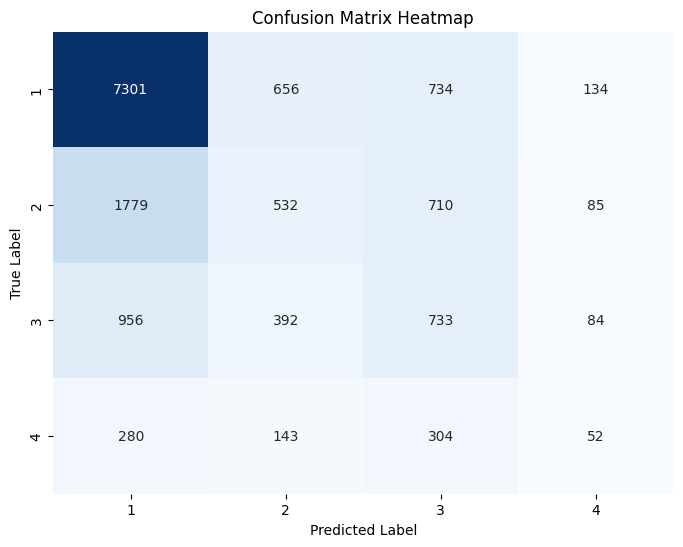

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig('heatmap00011_output.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
X_test_scaled

,Order Day Number,Order Priority,Sales,Discount,Profit,Quantity,Market_Africa,Market_Apac,Market_Canada,Market_Emea,...,Region_Emea,Region_North,Region_North Asia,Region_Oceania,Region_South,Region_Southeast Asia,Region_West,Segment_Consumer,Segment_Corporate,Segment_Home Office
5,1.0,0.0,-0.294510,0.0,-0.064022,1.5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
10,-1.0,1.0,-0.325820,0.0,-0.071690,-0.5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
32,0.5,1.0,0.567076,0.0,1.244782,-0.5,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
33,0.5,1.0,-0.356012,0.0,-0.158858,-1.0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
34,0.5,1.0,-0.096493,0.0,0.224471,-1.0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49607,-1.0,0.0,-0.271587,0.0,0.029738,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
49616,0.5,0.0,-0.268046,0.0,0.094756,0.5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
49619,0.0,0.0,1.246290,0.0,0.816053,-0.5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49631,0.0,0.0,0.542288,0.0,2.266119,-0.5,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [44]:
class CustomOneVsRestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers):
        self.classifiers = classifiers
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if len(self.classifiers) != len(self.classes_):
            raise ValueError("Number of classifiers must match number of classes.")
        self.models_ = []
        for i, clf in enumerate(self.classifiers):
            binary_y = (y == self.classes_[i]).astype(int)
            clf.fit(X, binary_y)
            self.models_.append(clf)
        return self

    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.models_)))
        for i, clf in enumerate(self.models_):
            if hasattr(clf, "predict_proba"):
                scores[:, i] = clf.predict_proba(X)[:, 1]
            else:
                scores[:, i] = clf.decision_function(X)
        return self.classes_[np.argmax(scores, axis=1)]

    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], len(self.models_)))
        for i, clf in enumerate(self.models_):
            if hasattr(clf, "predict_proba"):
                proba[:, i] = clf.predict_proba(X)[:, 1]
            else:
                scores = clf.decision_function(X)
                proba[:, i] = (scores - scores.min()) / (scores.max() - scores.min())
        return proba

classifiers = [
    RandomForestClassifier(n_estimators=300,max_depth=15,n_jobs = -1, random_state=42),
    MLPClassifier(
    hidden_layer_sizes=(180,70), 
    activation='relu',          
    solver='adam',              
    alpha=0.01,                
    learning_rate='adaptive',   
    learning_rate_init=0.01,   
    max_iter=400,               
    batch_size=164,             
    early_stopping=True,        
    validation_fraction=0.1,    
    random_state=42       
    ),
    RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42),
    xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, scale_pos_weight=3, random_state=42)
]

pipeline = Pipeline(steps=[('classifier', CustomOneVsRestClassifier(classifiers))])
pipeline.fit(X_train_resampled_scaled, y_train_resampled['Ship Mode'])

proba = pipeline.predict_proba(X_test_scaled)

proba_df = pd.DataFrame(proba, columns=[f'Class_{i}' for i in [1, 2, 3, 4]], index=X_test_scaled.index)
print("Predicted Probabilities for X_test_scaled (first 5 samples):")
print(proba_df.head())

#predict
y_pred = pipeline.predict(X_test_scaled)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print()
print(classification_report(y_test, y_pred))
print("Example: Probabilities and Predicted Class for first sample:")
print()
sample_idx = 0
print(f"Probabilities: {dict(zip([1, 2, 3, 4], proba[sample_idx]))}")
print(f"Predicted Class: {y_pred[sample_idx]}")
print(f"True Class: {y_test.iloc[sample_idx]}")

Predicted Probabilities for X_test_scaled (first 5 samples):
     Class_1   Class_2   Class_3   Class_4
5   0.487198  0.328890  0.196176  0.034138
10  0.186800  0.328995  0.250714  0.326102
32  0.225212  0.328996  0.231921  0.389890
33  0.233297  0.298778  0.127915  0.498772
34  0.176325  0.328996  0.271133  0.390583

Accuracy: 0.55
Classification Report:

              precision    recall  f1-score   support

           1       0.73      0.78      0.75      8825
           2       0.30      0.21      0.25      3106
           3       0.29      0.22      0.25      2165
           4       0.12      0.21      0.15       779

    accuracy                           0.55     14875
   macro avg       0.36      0.36      0.35     14875
weighted avg       0.54      0.55      0.54     14875

Example: Probabilities and Predicted Class for first sample:

Probabilities: {1: 0.4871984010210066, 2: 0.3288902219142451, 3: 0.19617636010464834, 4: 0.03413841500878334}
Predicted Class: 1
True Class: Shi

In [45]:
proba_df

,Class_1,Class_2,Class_3,Class_4
5,0.487198,0.328890,0.196176,0.034138
10,0.186800,0.328995,0.250714,0.326102
32,0.225212,0.328996,0.231921,0.389890
33,0.233297,0.298778,0.127915,0.498772
34,0.176325,0.328996,0.271133,0.390583
...,...,...,...,...
49607,0.388594,0.303183,0.260704,0.132394
49616,0.435778,0.363418,0.167561,0.069674
49619,0.514019,0.328996,0.104446,0.052790
49631,0.493400,0.384356,0.099738,0.038862


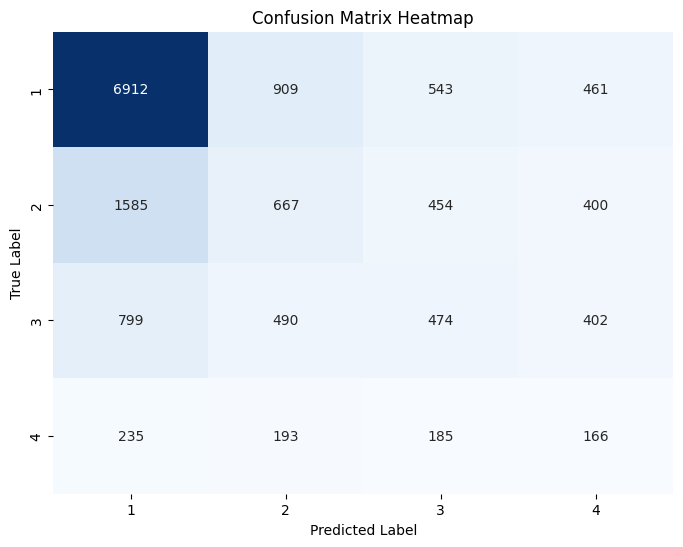

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig('heatmap0001_output.png', dpi=300, bbox_inches='tight')
plt.show()